In [1]:
import numpy as np
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.constants as constants

import sys
import os

dir_current = globals()['_dh'][0]
dir_repo = dir_current+'/../..'
dir_BinnedFit = dir_repo+"/BinnedFit"
dir_KLens = dir_repo+"/KLens"

sys.path.append(dir_BinnedFit)
from gen_mocks import gen_mock_tfCube
from spec2D import Spec2D
from gaussFit import GaussFit, GaussFitDouble
from chainTool import ChainTool

sys.path.append(dir_KLens)
from KLtool import plot_specs

from IPython.display import display as ipython_display

In [2]:
###### set up parameters ######

line_species='Halpha'

pars = {}
pars['g1'] = 0.05
pars['g2'] = 0.05
pars['sini'] = 0.5

pars['redshift'] = 0.4

pars['aspect'] = 0.2
pars['r_hl_image'] = 0.5
pars['r_hl_spec'] = 0.5

pars['theta_int'] = 0. #np.pi/3.

pars['slitWidth'] = 0.12
pars['ngrid'] = 128

pars['norm'] = 0.0

pars['Resolution'] = 5000.
pars['expTime'] = 60.*30. #60.*30.
pars['pixScale'] = 0.1185
pars['nm_per_pixel'] = 0.033
pars['throughput'] = 0.29
pars['psfFWHM'] = 0.5

pars['area'] = 3.14 * (1000./2.)**2 

pars['vcirc'] = 200.

linelist = np.empty(5,dtype=[('species',np.str_,16),
                                  ('lambda',np.float),
                                  ('flux',np.float)])
linelist['species'] = ['OIIa','OIIb','OIIIa','OIIIb','Halpha']
linelist['lambda'] =  [372.7092,372.9875,496.0295,500.8240,656.461]

fiber_SDSS = np.pi * 1.5**2
refSDSSspec = 3.*1e-17 * u.erg/u.second/u.Angstrom/u.cm**2
refSDSSspec = refSDSSspec.to(u.erg/u.second/u.nm/u.cm**2)

linelist['flux'] = refSDSSspec.value / fiber_SDSS  # [unit: erg/s/cm2/nm/arcsec2]

pars['linelist'] = linelist

# GaussFit

In [3]:
dataInfo = gen_mock_tfCube(pars, line_species, slits='major', noise_mode=0)
spec2D = dataInfo['spec'][0]

## 0. check spec2D data

/Users/hhg/Research/kinematic_lensing/repo/BinnedFit/notebook/../../BinnedFit/spec2D.py:216: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 468x324 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb428922110>)

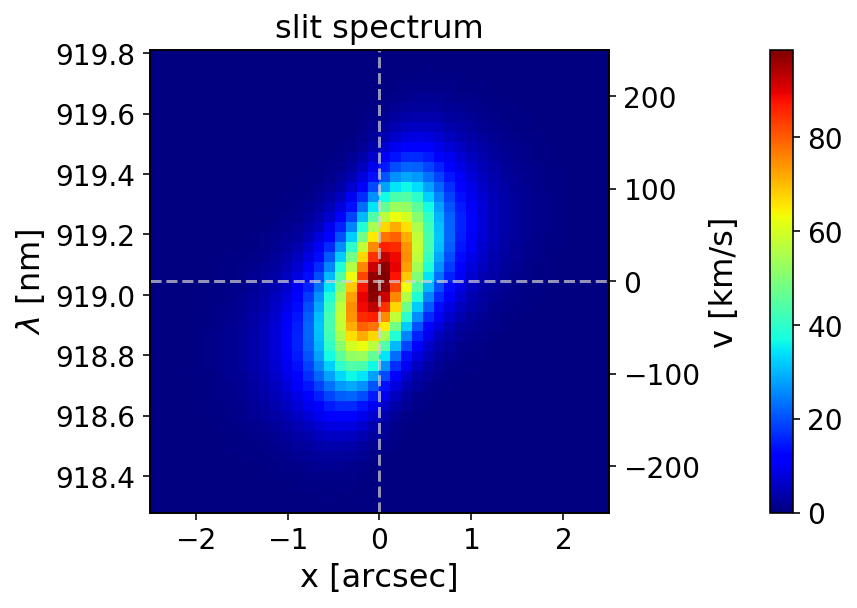

In [4]:
spec2D.display(xlim=[-2.5, 2.5], vlim=[-250,250], mark_cen=True)

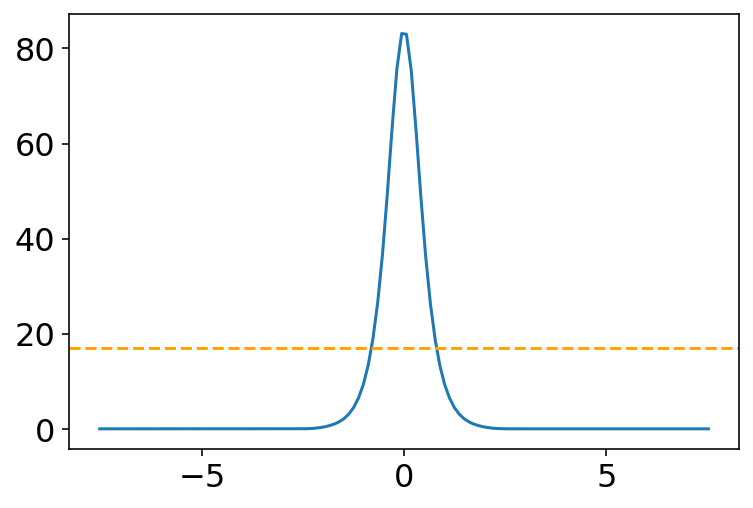

In [5]:
thresholdSNR = 17
plt.plot(spec2D.spaceGrid, spec2D.SNR_pos)
plt.axhline(y=thresholdSNR, color='orange', ls='--')

## 1. start GaussFit

In [6]:
GF = GaussFit(spec2D=spec2D)

In [7]:
cenLambda, amp, sigma = GF.fit_spec2D()

time cost in gaussFit_spec2D: 0.05861091613769531 (secs)


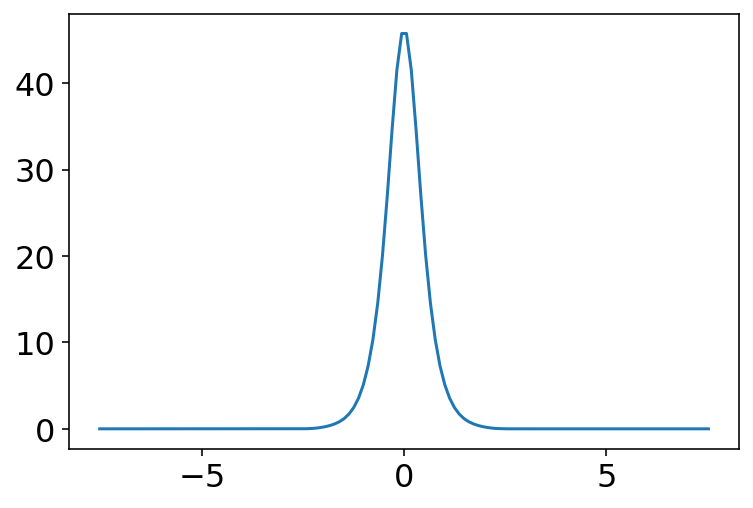

In [8]:
plt.plot(spec2D.spaceGrid, amp)

### 1.1 display overall best-fit model

time cost in gaussFit_spec2D: 0.11148810386657715 (secs)
chi2: 0.0002234320148508771
reduced chi2: 1.466859341195359e-08


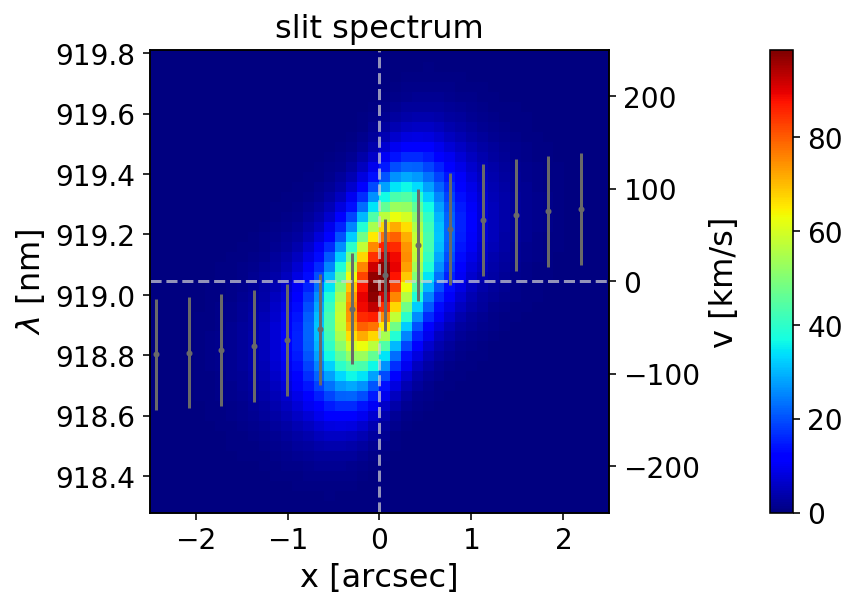

In [9]:
model2D = Spec2D(GF.model, GF.spec2D.array_var, GF.spec2D.spaceGrid, GF.spec2D.lambdaGrid, 
                 line_species=GF.spec2D.line_species, z=GF.spec2D.z)
fig, ax = model2D.display(xlim=[-2.5,2.5], vlim=[-250,250], mark_fit=True)

print(f'chi2: {GF.chi2}')
print(f'reduced chi2: {GF.reduced_chi2}')

## 2. check gaussian fit in 1D for position bin i

In [10]:
GF.spec2D.array.shape

(128, 122)

SNR = 83.14
peak lambda = 919.03 nm
peak amp = 45.76 photons
1 sigma = 0.18 nm


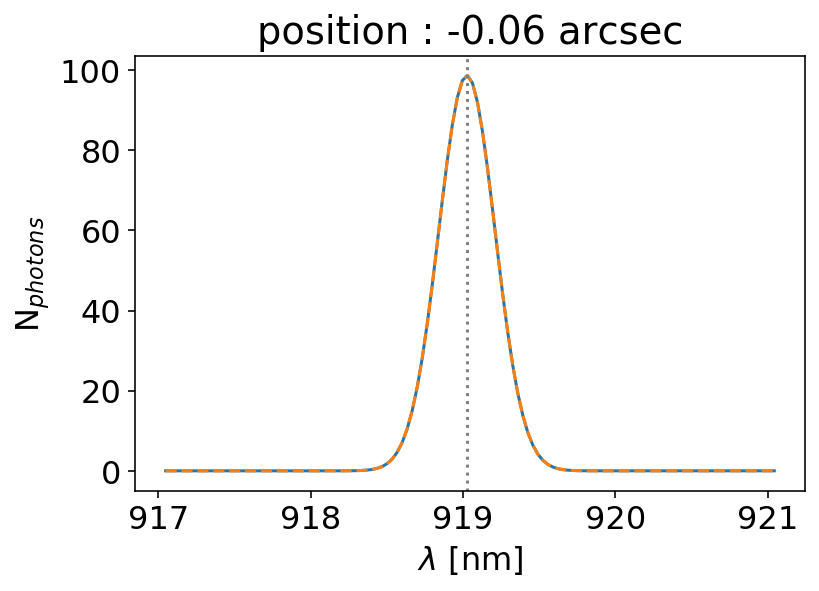

In [11]:
i=63

spec2D = dataInfo['spec'][0]
SNR = spec2D.SNR_pos

GF = GaussFit(spec2D)

best_vals = GF._fit_per_bin(pos_id=i)

# data
plt.plot(GF.spec2D.lambdaGrid, GF.spec2D.array[i])

# model
plt.plot(GF.spec2D.lambdaGrid, GF.gaussian(GF.spec2D.lambdaGrid, *best_vals), ls="--")
plt.axvline(x=best_vals[0], color='gray', ls=':')

plt.xlabel('$\lambda$ [nm]')
plt.ylabel('N$_{photons}$')


plt.title(f'position : {GF.spec2D.spaceGrid[i]:.2f} arcsec')
print(f'SNR = {SNR[i]:.2f}')
print(f'peak lambda = {best_vals[0]:.2f} nm')
print(f'peak amp = {best_vals[1]:.2f} photons')
print(f'1 sigma = {best_vals[2]:.2f} nm')

## 3. check residual

time cost in gaussFit_spec2D: 0.054644107818603516 (secs)


(<Figure size 468x324 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb428e87e50>)

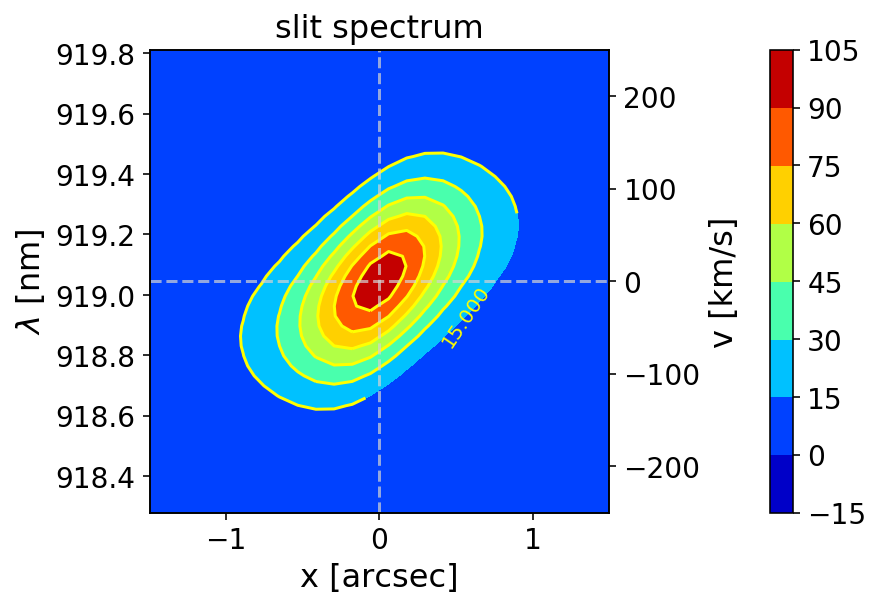

In [12]:
spec2D.display(xlim=[-1.5, 1.5], vlim=[-250,250], mark_cen=True, model=GF.model)

(<Figure size 468x324 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb428e6ff50>)

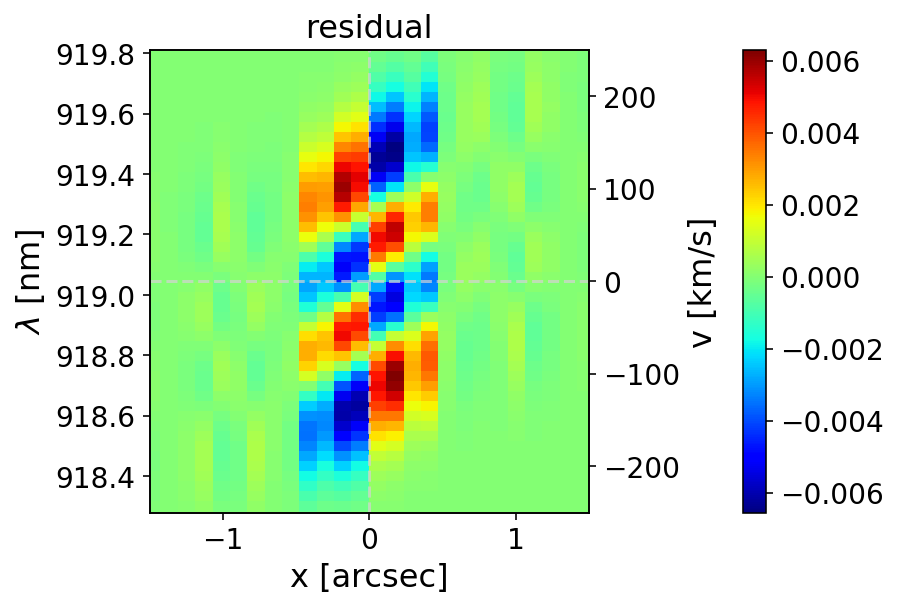

In [13]:
residual2D = Spec2D(spec2D.array-GF.model, GF.spec2D.array_var, GF.spec2D.spaceGrid, GF.spec2D.lambdaGrid, 
                    GF.spec2D.line_species, GF.spec2D.z)

residual2D.display(xlim=[-1.5, 1.5], vlim=[-250,250], mark_cen=True, title='residual')

# GaussFitDouble

In [14]:
dataInfo = gen_mock_tfCube(pars, line_species='OII', slits='major', noise_mode=1)
spec2D = dataInfo['spec'][0]

## 0. check spec2D data

(<Figure size 468x324 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb4189cf2d0>)

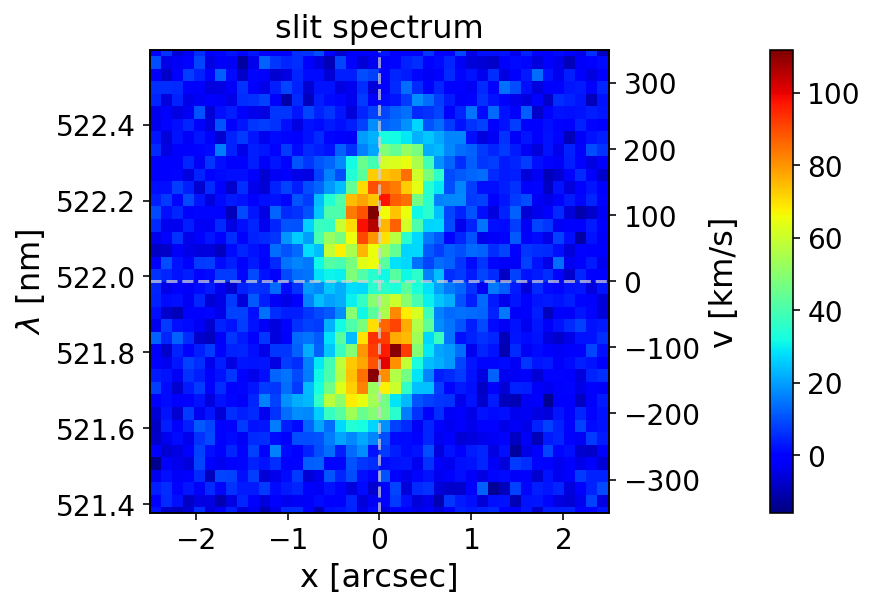

In [15]:
spec2D.display(xlim=[-2.5, 2.5], vlim=[-350,350], mark_cen=True)

## 1. start GaussFitDouble

In [16]:
GF = GaussFitDouble(spec2D=spec2D)

In [17]:
GF.thresholdSNR

20.44781182551333

/Users/hhg/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


RuntimeError for pos_id: 1. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 10. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 15. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 29. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 83. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 91. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 113. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 117. Set best-fit gaussian amp. = 0
time cost in gaussFit_spec2D: 0.41811680793762207 (secs)
RuntimeError for pos_id: 0. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 27. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 28. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 36. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 37. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 84. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 92. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 105. Set best-fit 

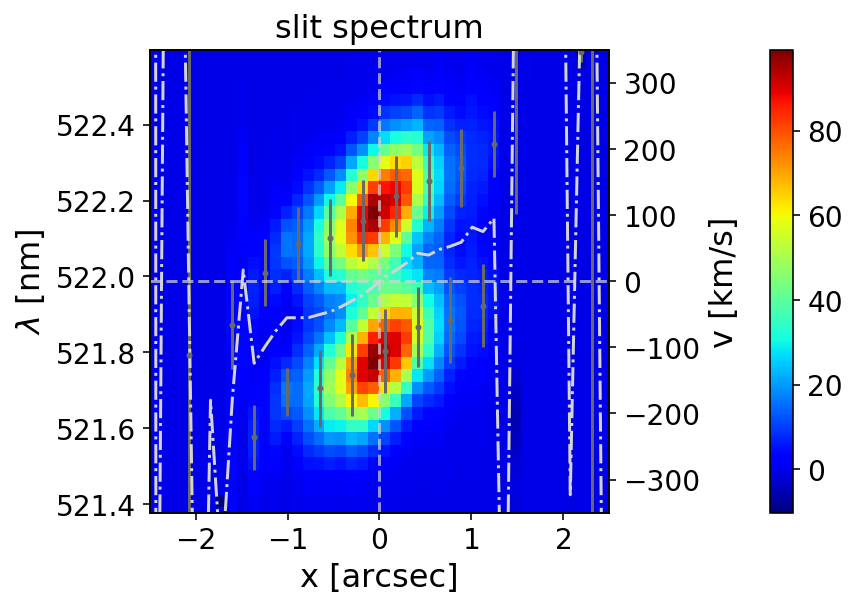

In [18]:
model2D = Spec2D(GF.model, GF.spec2D.array_var, 
                 GF.spec2D.spaceGrid, GF.spec2D.lambdaGrid, 
                 line_species=GF.spec2D.line_species, z=GF.spec2D.z)

fig, ax = model2D.display(xlim=[-2.5,2.5], vlim=[-350,350], mark_fit=True)

print(f'chi2: {GF.chi2}')
print(f'reduced chi2: {GF.reduced_chi2}')

## 2. check gaussian fit in 1D for position bin i

RuntimeError for pos_id: 10. Set best-fit gaussian amp. = 0
SNR = 22.76
peak lambda = 521.99 nm
peak amp = 0.00 photons
1 sigma = 10.00 nm


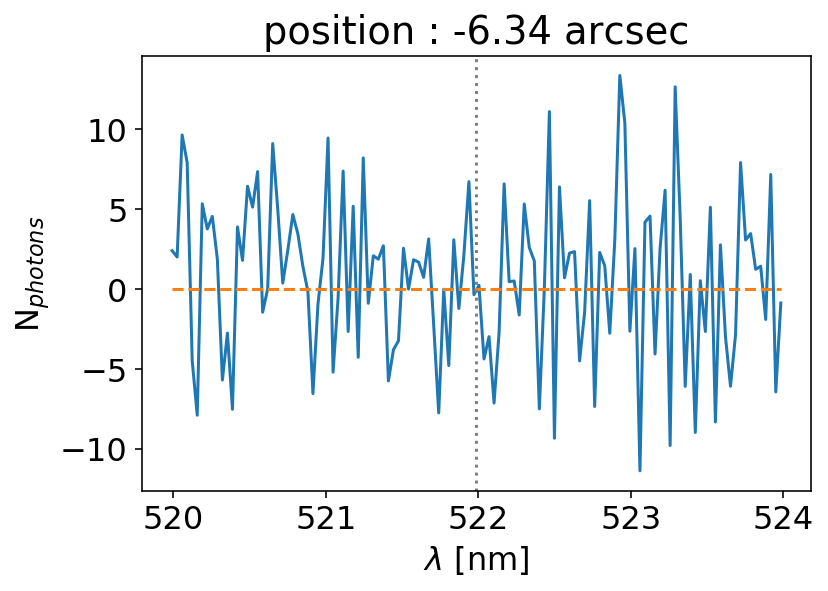

In [19]:
i=10

spec2D = dataInfo['spec'][0]
SNR = spec2D.SNR_pos

GF = GaussFitDouble(spec2D)

best_vals = GF._fit_per_bin(pos_id=i)

# data
plt.plot(GF.spec2D.lambdaGrid, GF.spec2D.array[i])

# model
plt.plot(GF.spec2D.lambdaGrid, GF.gaussian(GF.spec2D.lambdaGrid, *best_vals), ls="--")
plt.axvline(x=best_vals[0], color='gray', ls=':')

plt.xlabel('$\lambda$ [nm]')
plt.ylabel('N$_{photons}$')


plt.title(f'position : {GF.spec2D.spaceGrid[i]:.2f} arcsec')
print(f'SNR = {SNR[i]:.2f}')
print(f'peak lambda = {best_vals[0]:.2f} nm')
print(f'peak amp = {best_vals[1]:.2f} photons')
print(f'1 sigma = {best_vals[2]:.2f} nm')

## 3. check residual

RuntimeError for pos_id: 1. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 10. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 15. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 29. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 83. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 91. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 113. Set best-fit gaussian amp. = 0
RuntimeError for pos_id: 117. Set best-fit gaussian amp. = 0
time cost in gaussFit_spec2D: 0.4192192554473877 (secs)


(<Figure size 468x324 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb42925a1d0>)

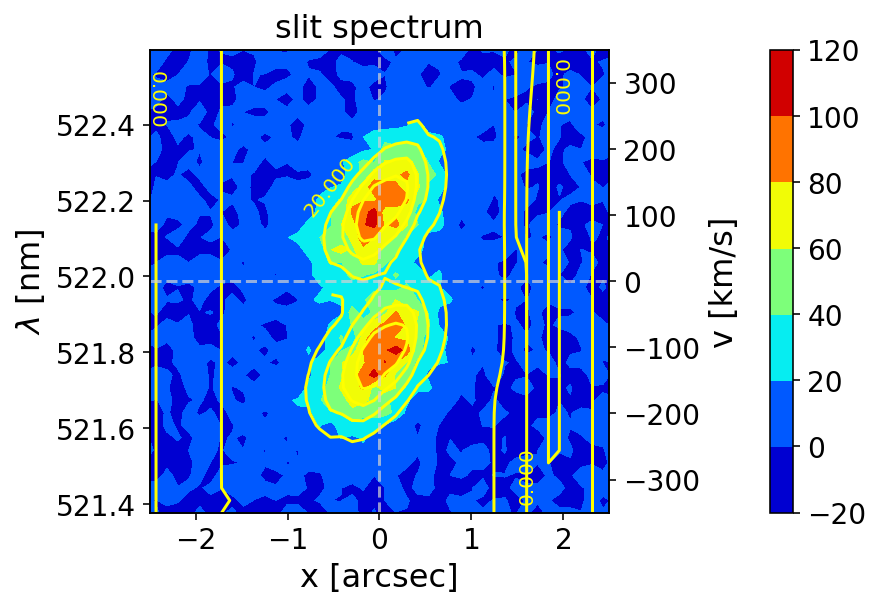

In [20]:
spec2D.display(xlim=[-2.5, 2.5], vlim=[-350,350], mark_cen=True, model=GF.model)

In [21]:
GF.reduced_chi2

3.6445511290439305

(<Figure size 468x324 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb418a0e050>)

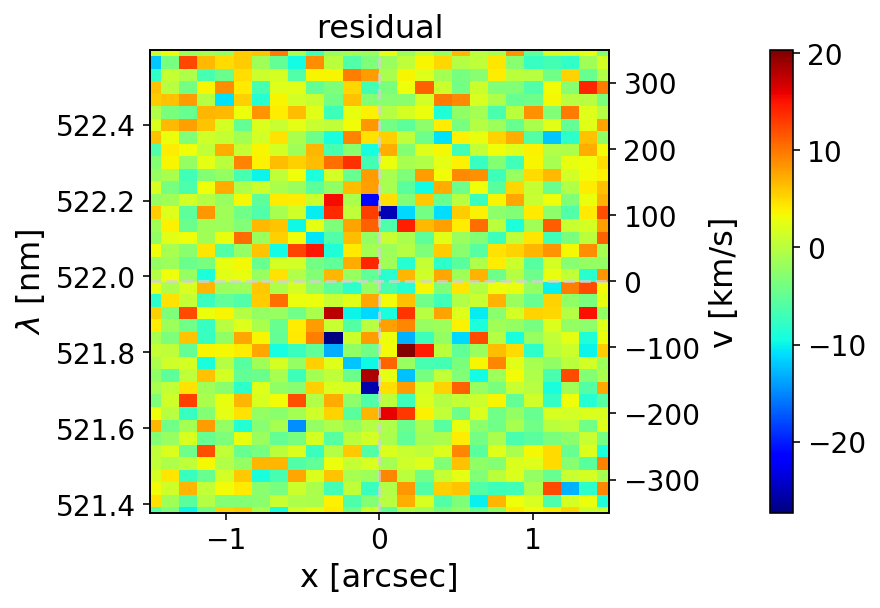

In [22]:
residual2D = Spec2D(spec2D.array-GF.model, GF.spec2D.array_var, GF.spec2D.spaceGrid, GF.spec2D.lambdaGrid, 
                    GF.spec2D.line_species, GF.spec2D.z)

residual2D.display(xlim=[-1.5, 1.5], vlim=[-350,350], mark_cen=True, title='residual')

## ---------- END ----------